In [3]:
%matplotlib inline

In [4]:
#!conda install scikit-image -y

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

import numpy as np
import os
import pandas as pd
from skimage import io, transform

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [6]:
### Loading FER data ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available:
#     print("CUDA is available.... 1 2 3...")

In [7]:
df_train = pd.read_csv("./FER-2013/train.csv")
df = pd.read_csv("./FER-2013/fer2013/fer2013.csv")
df_train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
df['pixelss']=[[int(y) for y in x.split()] for x in df['pixels']]

In [9]:
df.head()

,emotion,pixels,Usage,pixelss
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [10]:
df_train=df[df['Usage']=='Training']
df_valid=df[df['Usage']=='PrivateTest']
df_test=df[df['Usage']=='PublicTest']

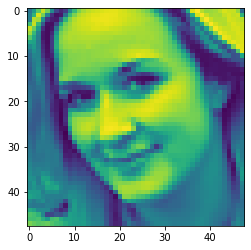

In [11]:
im=np.array(df['pixelss'][6969])
img=im.reshape(48,48)
plt.imshow(img, interpolation='nearest')
plt.show()

In [12]:
part={}
part['train']= list(range(0,len(df_train)))
part['valid']= list(range(0,len(df_valid)))
part['test']= list(range(0,len(df_test)))
train_labels=df_train['emotion'].tolist()
valid_labels=df_valid['emotion'].tolist()
test_labels=df_test['emotion'].tolist()

In [13]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff=dff

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixelss']
        X = np.array(X).reshape(48,48,1)
        y = self.dff.iloc[index]['emotion']

        if self.transforms:
          X = self.transforms(X)
        
        X = torch.cat((X,X,X),0)

        return X, y

In [14]:
params = {'batch_size': 64,'shuffle': True,'num_workers': 10}

In [15]:
from torch.utils import data
import pandas as pd
import albumentations
from albumentations import pytorch as AT
from tqdm import tqdm
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
#from torchsummary import summary
from collections import OrderedDict
import torch.optim as optim

class AlbumentationWrapper(object):
    def __init__(self,split):
        self.split=split
        self.aug=albumentations.Compose([                                         
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()
    ])
	
        if self.split=='train':
            self.aug=albumentations.Compose([
                                             
            #albumentations.Resize(48,48),
    albumentations.HorizontalFlip(),
    albumentations.Cutout(2,2,2,0.5),
    albumentations.GaussNoise(),
    #albumentations.ElasticTransform(),    
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()    
    ])
            
    def __call__(self,img):
        #img = np.array(img)
        img = self.aug(image=img)['image']
        return img

In [16]:
train_transforms , validation_transforms=AlbumentationWrapper('train'), AlbumentationWrapper('test')

In [17]:
training_set = Dataset(df_train, train_transforms)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(df_valid, validation_transforms)
validation_generator = data.DataLoader(validation_set, **params)

test_set = Dataset(df_test, validation_transforms)
test_generator = data.DataLoader(test_set, **params)

In [18]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Test Accuracy")

In [19]:
def train(model, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  running_loss = 0.0
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    running_loss += loss.item()
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} running_loss={running_loss} threshold={best_loss*(0.996)}')
    train_acc.append(100*correct/processed)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')

In [20]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

In [31]:
 class Net(nn.Module):
        
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)            
         ) 

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)            
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        ) 
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(8 * 8 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        #####################################################


    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 8 * 8 * 32)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x


    def forward(self, x):
        x = self.stn(x)            # transform the input
        x = self.convblock1(x)     # Perform the usual forward pass
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)   
        x = self.convblock8(x) 
        x = self.convblock9(x)    
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

model=Net(1)
#model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

  0%|          | 0/449 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.0019999999999999983 


Loss=1.9494938850402832 Batch_id=1 le=0.0020000215288962613 Accuracy=10.16:   0%|          | 2/449 [01:08<4:01:44, 32.45s/it]